# Graph GFlowNet for sampling number in a 7-segment display

This tutorial demonstrates how to train a GFlowNet to generate valid numbers in a 7-segment display.

## Setup

Let's first import all the necessary libraries:

In [1]:
import time

import matplotlib.pyplot as plt
import torch
from tensordict import TensorDict
from matplotlib import patches

from gfn.containers import ReplayBuffer
from gfn.gflownet.trajectory_balance import TBGFlowNet
from gfn.gym.graph_building import GraphBuildingOnEdges
from gfn.modules import DiscreteGraphPolicyEstimator
from gfn.states import GraphStates
from gfn.utils.modules import GraphEdgeActionGNN
from gfn.actions import GraphActionType
from gfn.utils.graphs import get_edge_indices


torch.random.manual_seed(7)
device = torch.device('cpu')

/home/oyounis-iit.local/anaconda3/envs/torchgfn/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Defining the Reward Function

A crucial component of GFlowNet training is the reward function. In this tutorial, we aim to sample graphs that represent valid digits on a seven-segment display. Each display is represented as a graph with 6 nodes and up to 7 edges (segments).

The 6 nodes are arranged in a 2x3 grid:
```
(0) ---s0--- (1)
 |           |
s1          s2
 |           |
(2) ---s3--- (3)
 |           |
s4          s5
 |           |
(4) ---s6--- (5)
```
The 7 segments (edges) are:
- s0: (0,1) - top
- s1: (0,2) - top-left
- s2: (1,3) - top-right
- s3: (2,3) - middle
- s4: (2,4) - bottom-left
- s5: (3,5) - bottom-right
- s6: (4,5) - bottom

The reward function will return 1.0 if the graph's edges form one of the valid digits (0-9), and $\epsilon$ otherwise.

In [2]:

# Define the canonical segments (as sorted node pairs) and their names
# Node layout:
# (0) --- (1)
#  |       |
# (2) --- (3)
#  |       |
# (4) --- (5)
#
# Segments:
# s0: (0,1), s1: (0,2), s2: (1,3), s3: (2,3), s4: (2,4), s5: (3,5), s6: (4,5)

SEGMENT_MAP = {
    (0,1): "s0", (0,2): "s1", (1,3): "s2",
    (2,3): "s3", (2,4): "s4", (3,5): "s5", (4,5): "s6"
}
# For undirected graphs, edge (u,v) is the same as (v,u).
# We store segments canonically, e.g. (min_node, max_node).

# Define valid digit patterns using segment names
DIGIT_PATTERNS = {
    0: {"s0", "s1", "s2", "s4", "s5", "s6"},
    1: {"s2", "s5"},
    2: {"s0", "s2", "s3", "s4", "s6"},
    3: {"s0", "s2", "s3", "s5", "s6"},
    4: {"s1", "s2", "s3", "s5"},
    5: {"s0", "s1", "s3", "s5", "s6"},
    6: {"s0", "s1", "s3", "s4", "s5", "s6"},
    7: {"s0", "s2", "s5"},
    8: {"s0", "s1", "s2", "s3", "s4", "s5", "s6"},
    9: {"s0", "s1", "s2", "s3", "s5", "s6"}
}
# Precompute a set of frozensets for quick lookup of valid segment combinations
VALID_DIGIT_SEGMENT_SETS = {frozenset(segments) for segments in DIGIT_PATTERNS.values()}

def get_graph_segment_names(graph_state_data: object) -> frozenset:
    """Extracts active segment names from a graph's edge_index."""
    active_segments = set()
    # graph_state_data is expected to be a PyTorch Geometric Data object
    # or a similar structure that has edge_index and num_nodes attributes.

    current_edge_index = getattr(graph_state_data, 'edge_index', None)
    num_nodes = getattr(graph_state_data, 'num_nodes', 0)

    if num_nodes != 6: # Segments are defined for 6 nodes
        return frozenset() # Or handle as an error/invalid state appropriately

    if current_edge_index is None or current_edge_index.numel() == 0:
        return frozenset()

    # Edge index is [2, num_edges]. Iterate over columns.
    for i in range(current_edge_index.size(1)):
        u, v = current_edge_index[0, i].item(), current_edge_index[1, i].item()
        # Canonicalize edge to (min_node, max_node)
        canonical_edge = tuple(sorted((u, v)))
        if canonical_edge in SEGMENT_MAP:
            active_segments.add(SEGMENT_MAP[canonical_edge])
    return frozenset(active_segments)

def reward_function(states: GraphStates) -> torch.Tensor:
    """Computes reward for seven-segment digit graphs.

    Reward is 1.0 if the graph is a valid digit, 0.0 otherwise.
    GFlowNets typically prefer R > 0. If training struggles with 0.0 for invalid states,
    a small positive epsilon (e.g., 1e-9) could be used instead.

    Args:
        states: A batch of graph states to evaluate.

    Returns:
        A boolean tensor indicating validity for each graph.
    """
    batch_size = len(states)
    is_valid = torch.full((batch_size,), 1e-4)

    for i in range(batch_size):
        graph_data = states[i].tensor # This is expected to be the PyG Data object
        # graph_data has .num_nodes and .edge_index
        if getattr(graph_data, 'num_nodes', 0) != 6:
            continue

        active_segment_names = get_graph_segment_names(graph_data)
        if active_segment_names in VALID_DIGIT_SEGMENT_SETS:
            is_valid[i] = 1.0
    return is_valid


## Visualization Function

To understand what the model is generating and visualize the generated digits, we need a visualization function:

In [3]:
NODE_POSITIONS = {
    0: (0.5, 2), 1: (1.5, 2),  # Top row
    2: (0.5, 1), 3: (1.5, 1),  # Middle row
    4: (0.5, 0), 5: (1.5, 0),  # Bottom row
}

SEGMENT_NODES = { # For drawing
    "s0": (0, 1), "s1": (0, 2), "s2": (1, 3),
    "s3": (2, 3), "s4": (2, 4), "s5": (3, 5), "s6": (4, 5)
}

def get_digit_from_segments(active_segments_fset: frozenset) -> str:
    """Identifies the digit from a frozenset of active segment names."""
    for digit, segments_set in DIGIT_PATTERNS.items():
        if active_segments_fset == segments_set:
            return str(digit)
    return "Unknown"

def render_states(states: GraphStates):
    """Visualize a batch of graph states as seven-segment displays.

    This function creates a matplotlib visualization of graph states, rendering them
    as seven-segment displays.

    The visualization includes:
    - Nodes representing the 6 points of the display.
    - Drawing active segments (edges) between connected nodes.
    - Displaying whether the graph forms a valid digit.

    Args:
        states: A batch of graphs to visualize.
    """
    fig, ax = plt.subplots(2, 4, figsize=(12, 6))
    ax = ax.flatten() # Flatten to 1D array for easier indexing

    validity_tensor = reward_function(states) == 1.0

    for i in range(min(8, len(states))): # Display up to 8 graphs or fewer if batch is smaller
        current_ax = ax[i]
        state_data = states[i].tensor

        title = "Invalid Graph"
        is_valid_current_graph = False

        if getattr(state_data, 'num_nodes', 0) == 6:
            active_segments_fset = get_graph_segment_names(state_data)
            if validity_tensor[i].item(): # Use pre-computed validity
                digit_char = get_digit_from_segments(active_segments_fset)
                title = f"Valid Digit: {digit_char}"
                is_valid_current_graph = True
            else:
                title = "Invalid Segments"
        else:
            title = f"Nodes: {getattr(state_data, 'num_nodes', 0)} (not 6)"

        # Draw all 6 nodes
        for node_idx, pos in NODE_POSITIONS.items():
            current_ax.add_patch(
                patches.Circle(pos, 0.05, facecolor="lightgray", edgecolor="black")
            )

        # Draw active segments
        if getattr(state_data, 'num_nodes', 0) == 6:
            active_segments_fset = get_graph_segment_names(state_data) # Re-get for drawing
            for segment_name, (u_node, v_node) in SEGMENT_NODES.items():
                if segment_name in active_segments_fset:
                    pos_u = NODE_POSITIONS[u_node]
                    pos_v = NODE_POSITIONS[v_node]
                    current_ax.plot([pos_u[0], pos_v[0]], [pos_u[1], pos_v[1]], color="black", linewidth=3)

        current_ax.set_title(title)
        current_ax.set_xlim(-0.5, 2.5)
        current_ax.set_ylim(-0.5, 2.5)
        current_ax.set_aspect("equal")
        current_ax.set_xticks([])
        current_ax.set_yticks([])

    plt.tight_layout()
    plt.show()

## Environment and policy estimator 

Let's define the environment using our seven-segment reward function. The GFN will learn to generate graphs with 6 nodes, where edges represent segments of a display.
The action space for the `GraphBuildingOnEdges` is discrete, so we will also define the `DiscreteGraphPolicyEstimator` for it. As typical with GFlowNets, we will have two policies, one for the forward step and one for backward.

In [4]:
INVALID_EDGES = torch.tensor([
    [i0, i1]
    for i0 in range(6) for i1 in range(6)
    if (i0, i1) not in SEGMENT_MAP.keys()
])

class SevenSegmentGraphBuilding(GraphBuildingOnEdges):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    
    def make_states_class(self) -> type[GraphStates]:
        env = self
        GraphBuildingOnEdgesStates = super().make_states_class()

        class SevenSegmentGraphBuildingStates(GraphBuildingOnEdgesStates):
            """Represents the state of a seven-segment display graph building process."""

            @property
            def forward_masks(self) -> TensorDict:
                forward_masks = super().forward_masks

                ei0, ei1 = get_edge_indices(n_nodes=6, is_directed=False, device=self.device)
                edge_idx = torch.logical_and(
                    INVALID_EDGES[0][..., None] == ei0[None],
                    INVALID_EDGES[1][..., None] == ei1[None],
                ).to(self.device)

                edge_idx = edge_idx.sum(0).bool()

                forward_masks["edge_index"][..., edge_idx] = False
                forward_masks["action_type"][..., GraphActionType.ADD_EDGE] = torch.any(forward_masks["edge_index"], dim=-1)

                return forward_masks            
    
        return SevenSegmentGraphBuildingStates
            

In [6]:
directed = False
n_nodes = 6  # 6 nodes for the seven-segment display
env = SevenSegmentGraphBuilding(
    n_nodes=n_nodes,
    state_evaluator=reward_function,
    directed=directed,
    device=device,
)


pf = DiscreteGraphPolicyEstimator(
    module=GraphEdgeActionGNN(
        env.n_nodes,
        directed=directed,
        num_edge_classes=env.num_edge_classes,
        embedding_dim=32,
    )
)
pb = DiscreteGraphPolicyEstimator(
    module=GraphEdgeActionGNN(
        env.n_nodes,
        directed=directed,
        is_backward=True,
        num_edge_classes=env.num_edge_classes,
        embedding_dim=32,
    ),
    is_backward=True,
)

gflownet = TBGFlowNet(pf, pb).to(device)

## Sampling before training

Let's sample graphs using the untrained policy to see the initial distribution of generated seven-segment displays.

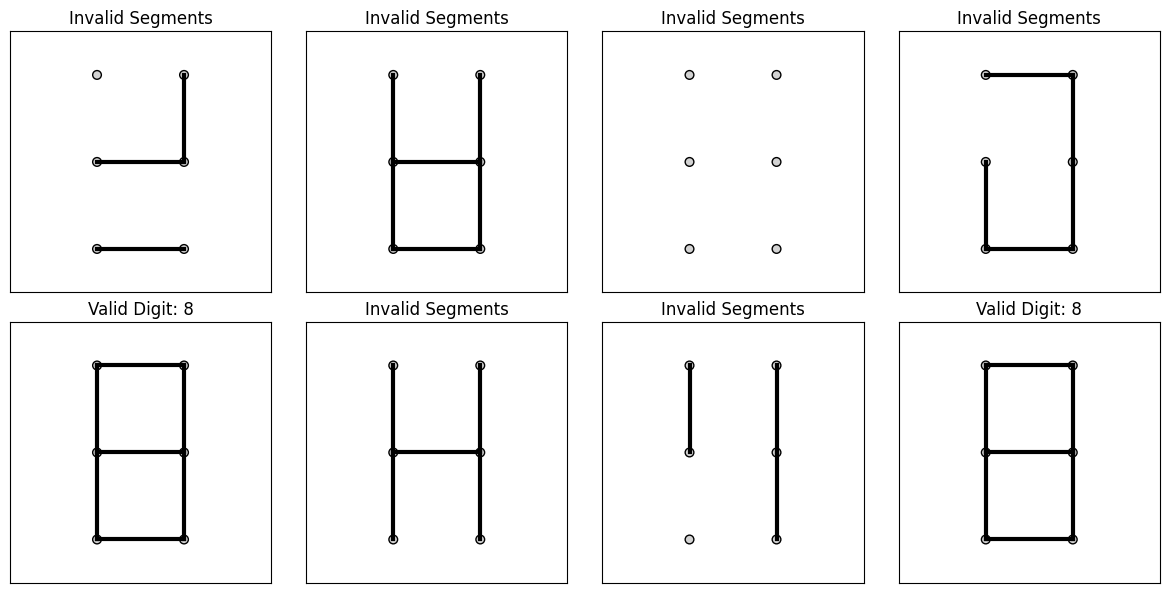

Before training: 8 valid digits out of 64 samples (12.50%)


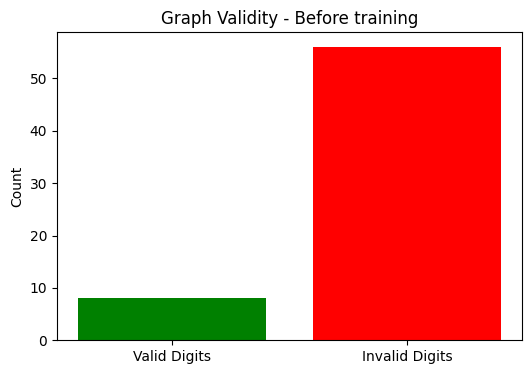

In [8]:
trajectories = gflownet.sample_trajectories(env, n=64)
terminating_states = trajectories.terminating_states
render_states(terminating_states[:8])  # type: ignore


# Distribution of valid digits before training
validity_before = reward_function(terminating_states) == 1.0 # type: ignore
num_valid_before = validity_before.sum().item()
num_total_before = len(terminating_states)

print(f"Before training: {num_valid_before} valid digits out of {num_total_before} samples ({num_valid_before/num_total_before*100:.2f}%)")

# For plotting, we can show a simple bar chart: valid vs. invalid
labels = ['Valid Digits', 'Invalid Digits']
counts_before = [num_valid_before, num_total_before - num_valid_before]

plt.figure(figsize=(6, 4))
plt.title("Graph Validity - Before training")
plt.bar(labels, counts_before, color=['green', 'red'])
plt.ylabel("Count")
plt.show()

## Training

Let's write a training loop with Trajectory-Based GFlowNets, and using a ReplayBuffer. The model will learn to generate graphs that maximize the Mean Vertex Degree.


In [9]:
lr = 1e-3
batch_size = 128
n_iterations = 500

optimizer = torch.optim.Adam(gflownet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

replay_buffer = ReplayBuffer(
    env,
    capacity=batch_size,
    prioritized=True,
)

losses = []

print(f"Starting training on {device} device...")

t1 = time.time()
for iteration in range(n_iterations):
    trajectories = gflownet.sample_trajectories(
        env,
        n=batch_size,
        save_logprobs=True,
    )
    training_samples = gflownet.to_training_samples(trajectories)

    # Collect rewards for reporting.
    terminating_states = training_samples.terminating_states
    assert isinstance(terminating_states, GraphStates)

    optimizer.zero_grad()
    loss = gflownet.loss(env, training_samples, recalculate_all_logprobs=True)
    # Calculate mean reward (proportion of valid digits in the batch)
    mean_reward = reward_function(terminating_states).mean()
    
    if iteration % 10 == 0:
        print(
            "Iteration {} - Loss: {:.02f}, Mean Reward (Valid %): {:.02f}".format(
                iteration, loss.item(), mean_reward.item() # .item() to get Python number
            )
        )
        
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

t2 = time.time()
print(f"Training completed in {t2 - t1:.2f} seconds")

Starting training on cpu device...


/home/oyounis-iit.local/VSCode/torchgfn-1/src/gfn/utils/handlers.py:53: UserWarning: Recalculating logprobs for a container that already has them. This might be intended, if the log_probs were calculated off-policy.However, this is inefficient when training on-policy. In this case, you should instead call loss() or loss_from_trajectories() with recalculate_all_logprobs=False 
  warnings.warn(


Iteration 0 - Loss: 12.59, Mean Reward (Valid %): 0.10
Iteration 10 - Loss: 13.95, Mean Reward (Valid %): 0.54
Iteration 20 - Loss: 11.81, Mean Reward (Valid %): 0.27
Iteration 30 - Loss: 9.99, Mean Reward (Valid %): 0.33
Iteration 40 - Loss: 14.64, Mean Reward (Valid %): 0.35
Iteration 50 - Loss: 13.86, Mean Reward (Valid %): 0.30
Iteration 60 - Loss: 16.84, Mean Reward (Valid %): 0.22
Iteration 70 - Loss: 13.85, Mean Reward (Valid %): 0.19
Iteration 80 - Loss: 15.05, Mean Reward (Valid %): 0.31
Iteration 90 - Loss: 14.47, Mean Reward (Valid %): 0.33
Iteration 100 - Loss: 19.69, Mean Reward (Valid %): 0.38
Iteration 110 - Loss: 15.90, Mean Reward (Valid %): 0.37
Iteration 120 - Loss: 14.56, Mean Reward (Valid %): 0.45
Iteration 130 - Loss: 18.98, Mean Reward (Valid %): 0.40
Iteration 140 - Loss: 15.73, Mean Reward (Valid %): 0.36
Iteration 150 - Loss: 20.26, Mean Reward (Valid %): 0.48
Iteration 160 - Loss: 15.91, Mean Reward (Valid %): 0.48
Iteration 170 - Loss: 20.94, Mean Reward (V

## Sampling from Trained Models

We can use our trained models to generate graphs with high Mean Vertex Degree, and visualize them:

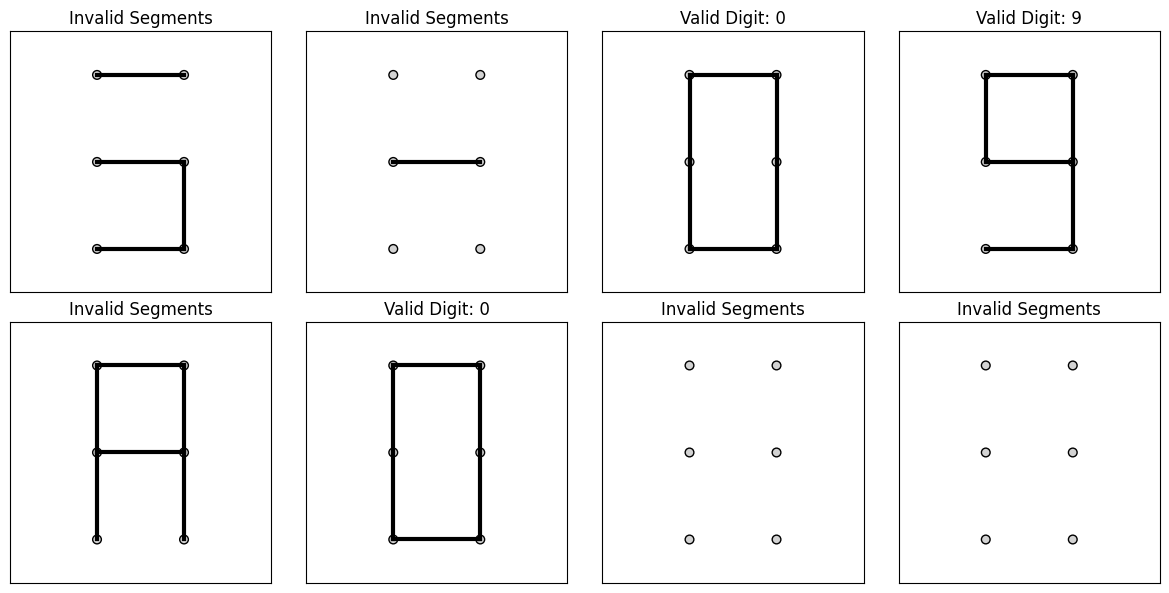

After training: 34 valid digits out of 64 samples (53.12%)


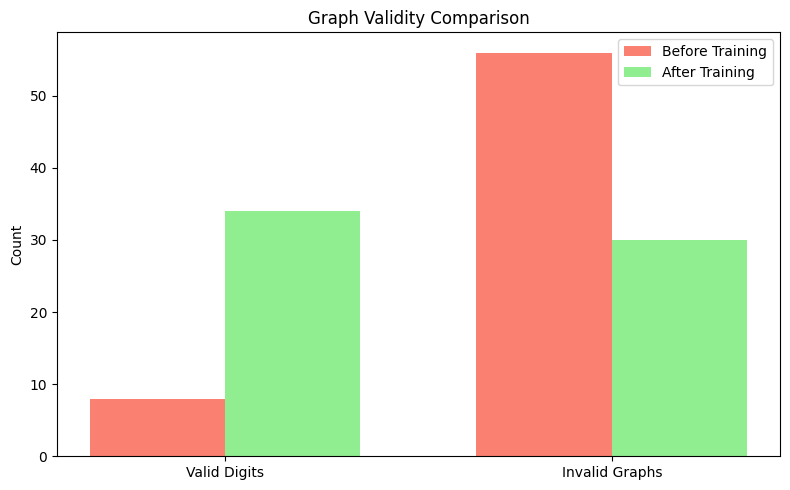

In [10]:
trajectories = gflownet.sample_trajectories(env, n=64)
terminating_states = trajectories.terminating_states
render_states(terminating_states[:8])  # type: ignore


# Distribution of valid digits after training
validity_after = reward_function(terminating_states) == 1.0 # type: ignore
num_valid_after = validity_after.sum().item()
num_total_after = len(terminating_states)

print(f"After training: {num_valid_after} valid digits out of {num_total_after} samples ({num_valid_after/num_total_after*100:.2f}%)")

# Plotting comparison
labels = ['Valid Digits', 'Invalid Graphs']
counts_after = [num_valid_after, num_total_after - num_valid_after]
# We need counts_before from the pre-training section. Assuming it's still in scope.
# If not, we might need to re-run that part or store it.
# For now, let's assume `counts_before` is available.

width = 0.35  # the width of the bars
x = torch.arange(len(labels))  # the label locations

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, counts_before, width, label='Before Training', color='salmon')
rects2 = ax.bar(x + width/2, counts_after, width, label='After Training', color='lightgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Graph Validity Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

## Conclusion

In this tutorial, we explored how to train a GFlowNet to generate graphs representing valid seven-segment display digits.

GFlowNets provide a powerful framework for learning to generate objects with desired properties by defining utility through reward functions. Here, a reward of 1 was given for graphs forming valid digits, and 0 otherwise. The GFlowNet learned to increase the proportion of valid digits sampled. This approach can be adapted to other discrete structure generation tasks where validity or desirability can be encoded in a reward signal.